In [2]:
from io import BytesIO
import os
import json

from IPython.display import display
import numpy as np
from PIL import Image
import requests

In [3]:
data_path = '/mnt/W/Users/Alt/Documents/CMU/11777/data/VG'

In [4]:
image_data_path = os.path.join(data_path, 'image_data.json')
objects_path = os.path.join(data_path, 'objects.json')
attributes_path = os.path.join(data_path, 'attributes.json')

In [5]:
with open(objects_path, 'r') as objects_file:
    objects_info_list = json.loads(objects_file.read())
objects_info = {obj['image_id']: obj
                for obj in objects_info_list}

with open(attributes_path, 'r') as attributes_file:
    attributes_info_list = json.loads(attributes_file.read())
attributes_info = {attr['image_id']: attr
                   for attr in attributes_info_list}

In [6]:
vocabulary_objects = set()
for objects_info_image in objects_info.values():
    for object_ in objects_info_image['objects']:
        vocabulary_objects.update(object_['names'])
vocabulary_objects = sorted(vocabulary_objects)
obj_to_ix = {name: ix for ix, name in enumerate(vocabulary_objects)}
        
vocabulary_attributes = set()
for attributes_info_image in attributes_info.values():
    for attributes_info_object in attributes_info_image['attributes']:
        attributes = attributes_info_object.get('attributes', {})
        vocabulary_attributes.update(attributes)
att_to_ix = {name: ix for ix, name in enumerate(vocabulary_attributes)}

In [7]:
def get_img(url):
    relative_image_path = url.split('/')[-2:]
    image_path = os.path.join(data_path, *relative_image_path)
    if not os.path.isfile(image_path):
        r = requests.get(url)
        r.raise_for_status()
        with open(image_path, 'wb') as image_file:
            image_file.write(r.content)
        return Image.open(BytesIO(r.content))
    return Image.open(image_path)

In [8]:
def preprocess_image(objects_info_image, attributes_info_image, display_images=False):    
    img = get_img(url=objects_info_image['image_url'])
    
    if display_images:
        display(img)
        print('Original image\n')

    objects = objects_info_image['objects']
    N = len(objects)

    attributes = attributes_info_image['attributes']
    attributes_dict = {object_['object_id']: object_.get('attributes', [])
                       for object_ in attributes}
    
    img_ids = np.ones(N, dtype=np.int) * objects_info_image['image_id']
    object_squares = np.empty((N, 224, 224, 3), dtype=np.uint8)
    original_sizes = np.empty(N, dtype=np.int)
    object_names = np.empty(N, dtype=np.int)
    attributes_names = []

    for i, (object_, attrs) in enumerate(zip(objects, attributes)):
        attrs = attributes_dict[object_['object_id']]
        attributes_names.append([att_to_ix[attr] for attr in attrs])
        original_sizes[i] = object_['w'] * object_['h']
        object_names[i] = obj_to_ix[object_['names'][0]]
        
        # Image processing
        cropped = img.crop((object_['x'],
                            object_['y'],
                            object_['x'] + object_['w'],
                            object_['y'] + object_['h']))
        resized = cropped.resize((224, 224))

        if display_images:
            display(resized)
            print(' - '.join(object_['names']))
            print()

        object_squares[i] = np.asarray(resized)

    return object_squares, img_ids, original_sizes, object_names, attributes_names

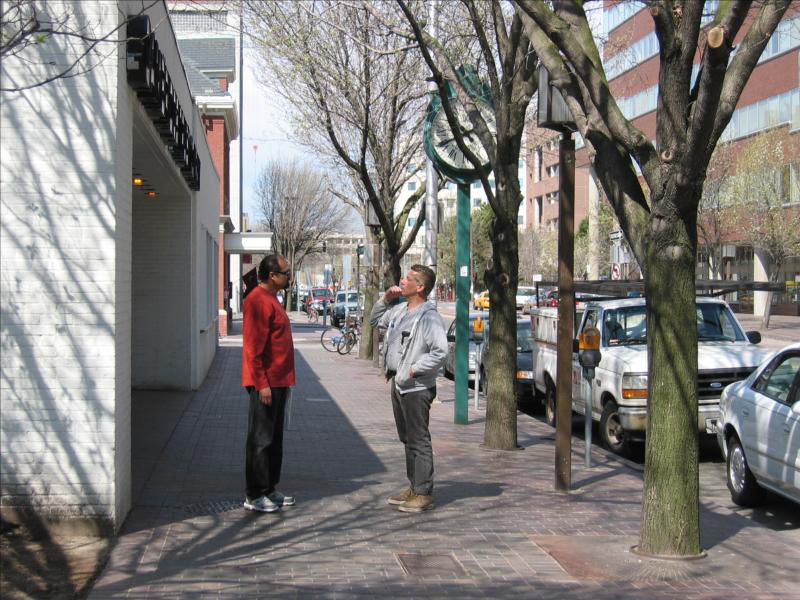

Original image



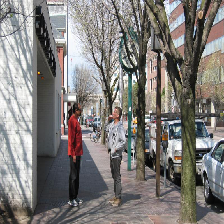

trees



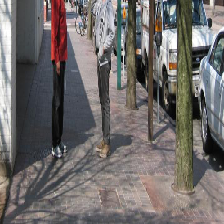

sidewalk



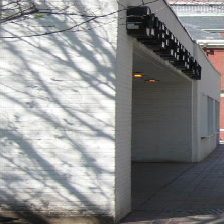

building



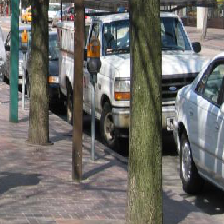

street



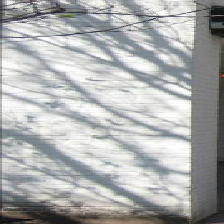

wall



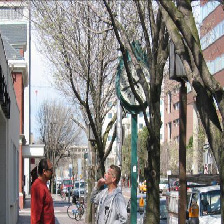

tree



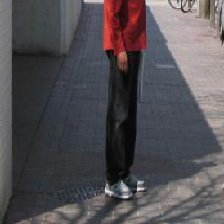

shade



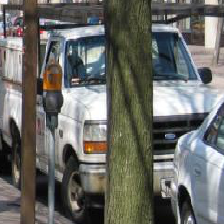

van



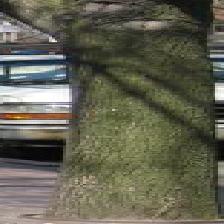

tree trunk



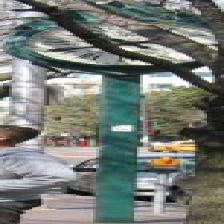

clock



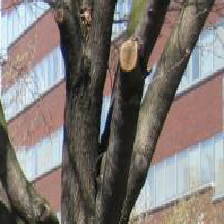

windows



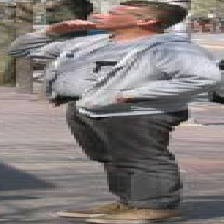

man



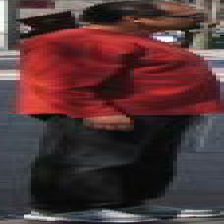

man



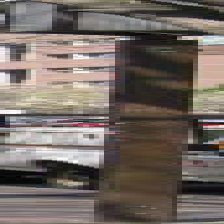

lamp post



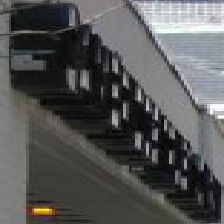

sign



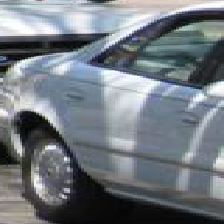

car



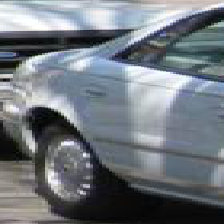

back



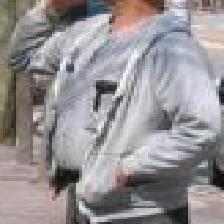

jacket



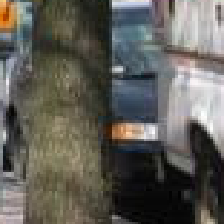

car



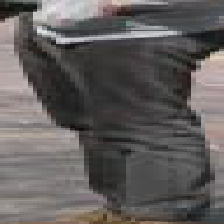

pants



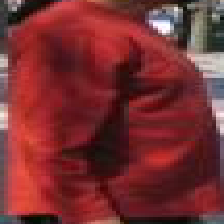

shirt



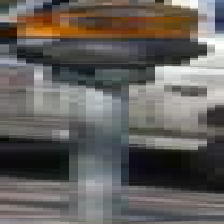

parking meter



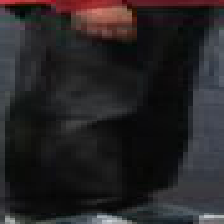

pants



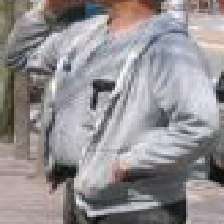

shirt



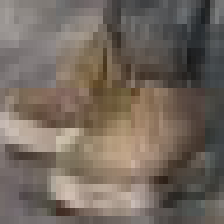

shoes



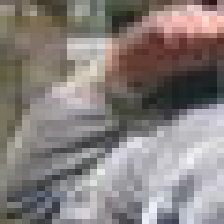

arm



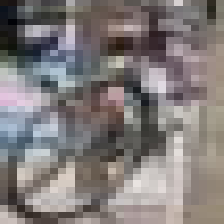

bike



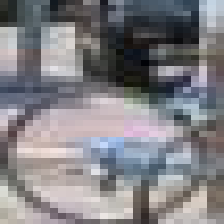

bike



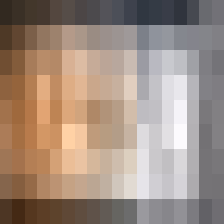

headlight



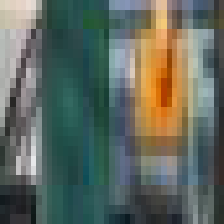

glasses



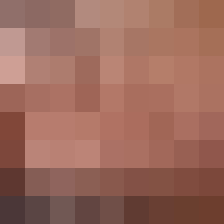

chin



In [9]:
preprocess_image(objects_info[1], attributes_info[1], display_images=True);

In [10]:
def preprocess_images(image_ids):
    failed = []
    
    object_squares = []
    img_ids = []
    original_sizes = []
    object_names = []
    attributes_names = []
    
    for image_id in image_ids:
        try:
            osq, ii, os, on, an = preprocess_image(objects_info[image_id], attributes_info[image_id])
        except requests.exceptions.HTTPError:
            failed.append(str(image_id))
        object_squares.append(osq)
        img_ids.append(ii)
        original_sizes.append(os)
        object_names.append(on)
        attributes_names += an
        
    if failed:
        print('Failed to load image(s) {}'.format(', '.join(failed)))
        
    return (np.concatenate(object_squares),
            np.concatenate(img_ids),
            np.concatenate(original_sizes),
            np.concatenate(object_names),
            attributes_names)

In [11]:
object_squares, img_ids, original_sizes, object_names, attributes_names = preprocess_images([1, 51, 52])

In [12]:
object_squares

array([[[[117, 115, 129],
         [161, 160, 165],
         [185, 185, 183],
         ..., 
         [ 41,  32,  25],
         [143, 124, 118],
         [148, 122, 121]],

        [[123, 121, 132],
         [227, 227, 229],
         [176, 176, 174],
         ..., 
         [ 61,  48,  40],
         [128, 105,  97],
         [132, 103,  99]],

        [[129, 128, 133],
         [237, 237, 235],
         [234, 234, 232],
         ..., 
         [137, 114, 106],
         [131,  98,  89],
         [114,  80,  71]],

        ..., 
        [[ 92,  79,  70],
         [ 85,  75,  65],
         [ 92,  84,  73],
         ..., 
         [160, 142, 142],
         [175, 157, 157],
         [187, 169, 169]],

        [[ 72,  59,  51],
         [ 96,  86,  77],
         [ 76,  67,  58],
         ..., 
         [168, 150, 150],
         [169, 151, 151],
         [175, 157, 157]],

        [[ 57,  48,  43],
         [ 68,  59,  54],
         [ 66,  59,  53],
         ..., 
         [166, 152, 151],
  

In [13]:
img_ids

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 51, 51, 51,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52])

In [14]:
original_sizes

array([445043, 209380, 119436,  92622,  72225, 171360,  51786,  42416,
        27144,  27951,  29106,  20336,  14763,  18490,  13962,  13120,
        11480,   8036,   7410,   6144,   5562,   3718,   5192,   8364,
         1344,   1230,    972,   1107,    162,    989,     72,  27348,
         2464,   5760,   6160,  16520,  14420,   8280,   7476,   4000,
         2891,   2332,   1794,   3036,   2312, 230911, 179550, 178177,
       156992, 124968, 123424, 184569,  96775,  61350,  49735,  54540,
        31500,  17472,   7178,  27903,  18318,  10332,   8034,   5616,
        23408,   4953,   1886,   6392,   3772,   1260,   3599,   1548,
          468,    119,    340,    126])

In [15]:
object_names

array([74034, 63310, 13055, 68464, 76783, 73836, 61972, 75955, 73984,
       17877, 80057, 43082, 43082, 39487, 63389, 14793,  4281, 37980,
       14793, 50451, 62568, 50821, 50451, 62568, 62706,  3387,  7173,
        7173, 35409, 31290, 16943, 14324, 14324, 14324, 14324, 14324,
       14324,  3425, 14324,  3425, 35318, 35318, 35318,  3425,  3425,
       64694, 77153, 59029, 77153, 59029, 77153, 28686, 64694, 64694,
       64694, 28686, 18131, 13055, 15892, 73836, 18131, 13055, 11836,
       13055, 18131, 59553, 10269, 71936, 13055, 48921, 71936, 13055,
       79849, 79849, 79849, 79849])

In [16]:
attributes_names

[[67764],
 [71245],
 [23693, 71245, 64099],
 [17628],
 [34605],
 [],
 [],
 [11954, 76781],
 [],
 [50100, 23693],
 [],
 [],
 [],
 [],
 [31970],
 [76781, 11954],
 [],
 [66652, 34605],
 [],
 [66652, 34605],
 [19466, 20052],
 [20052],
 [31970],
 [34605],
 [44671],
 [54604],
 [11954, 5467, 28690],
 [11954, 5467],
 [60405],
 [],
 [54604],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [54293],
 [],
 [],
 [],
 [],
 [],
 [],
 [50100],
 [76781],
 [],
 [44671],
 [50100],
 [25755],
 [],
 [],
 [19466, 71245],
 [25755],
 [31970],
 [76781],
 [],
 [],
 [78907],
 [],
 [],
 [],
 [],
 [],
 []]